# Training 3 using pre-trained InceptionV3

In [1]:
import tensorflow as tf

2024-01-14 23:47:06.335846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 23:47:06.478626: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 23:47:07.309085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2024-01-14 23:47:07.309183: W tensorflow/c

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from PIL import Image
import os
import scipy

In [4]:
train_dir = 'datasetX/trainX'
valid_dir = 'datasetX/validX'

In [5]:
# Define image dimensions and batch size
image_size = (299, 299)
batch_size = 32

In [6]:
# Data augmentation and preprocessing for the training and validation set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 13626 images belonging to 56 classes.
Found 1667 images belonging to 56 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

### Using pre-trained InceptionResNetV2 model

In [8]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

In [9]:
# Load the InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

2024-01-14 23:47:20.069450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11659 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6
2024-01-14 23:47:20.072345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 12951 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-14 23:47:20.076485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14169 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-01-14 23:47:20.077212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11757 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

219055592/219055592 [==============================] - 21s 0us/step


In [12]:
num_classes=56

In [13]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(299, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [14]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=40,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size
)

Epoch 1/40


2024-01-14 23:49:42.194111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2024-01-14 23:49:45.403752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


425/425 [==============================] - 305s 683ms/step - loss: 2.2743 - accuracy: 0.4118 - val_loss: 1.7455 - val_accuracy: 0.5120
Epoch 2/40
425/425 [==============================] - 288s 677ms/step - loss: 1.4464 - accuracy: 0.6035 - val_loss: 1.4513 - val_accuracy: 0.6004
Epoch 3/40
425/425 [==============================] - 296s 696ms/step - loss: 1.2129 - accuracy: 0.6612 - val_loss: 1.3327 - val_accuracy: 0.6166
Epoch 4/40
425/425 [==============================] - 286s 673ms/step - loss: 1.0720 - accuracy: 0.6929 - val_loss: 1.1585 - val_accuracy: 0.6701
Epoch 5/40
425/425 [==============================] - 286s 673ms/step - loss: 0.9788 - accuracy: 0.7230 - val_loss: 1.1376 - val_accuracy: 0.6845
Epoch 6/40
425/425 [==============================] - 287s 675ms/step - loss: 0.8927 - accuracy: 0.7423 - val_loss: 1.0918 - val_accuracy: 0.6929
Epoch 7/40
425/425 [==============================] - 276s 649ms/step - loss: 0.8410 - accuracy: 0.7551 - val_loss: 1.0703 - val_accura

In [53]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=5,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size
)

Epoch 1/5
425/425 [==============================] - 279s 656ms/step - loss: 0.3158 - accuracy: 0.8991 - val_loss: 0.9464 - val_accuracy: 0.7680
Epoch 2/5
425/425 [==============================] - 280s 658ms/step - loss: 0.3059 - accuracy: 0.9014 - val_loss: 1.0003 - val_accuracy: 0.7831
Epoch 3/5
425/425 [==============================] - 279s 657ms/step - loss: 0.3052 - accuracy: 0.9035 - val_loss: 0.9278 - val_accuracy: 0.7752
Epoch 4/5
425/425 [==============================] - 278s 654ms/step - loss: 0.2958 - accuracy: 0.9046 - val_loss: 0.9780 - val_accuracy: 0.7837
Epoch 5/5
425/425 [==============================] - 279s 655ms/step - loss: 0.2961 - accuracy: 0.9044 - val_loss: 1.0472 - val_accuracy: 0.7764


In [54]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=2,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size
)

Epoch 1/2
425/425 [==============================] - 278s 654ms/step - loss: 0.2930 - accuracy: 0.9078 - val_loss: 1.0733 - val_accuracy: 0.7680
Epoch 2/2
425/425 [==============================] - 281s 660ms/step - loss: 0.2971 - accuracy: 0.9068 - val_loss: 0.9552 - val_accuracy: 0.7885


In [55]:
test_dir = 'datasetX/testX'

In [56]:
# Data augmentation and preprocessing for the test set

test_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      horizontal_flip=True,
      zoom_range=0.2,
      shear_range=0.2,
      width_shift_range=0.1,
      height_shift_range=0.1

)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode= 'categorical'
)


Found 1738 images belonging to 56 classes.


In [57]:
#InceptionResNetV2
scores = model.evaluate(test_generator)

55/55 [==============================] - 31s 560ms/step - loss: 0.8326 - accuracy: 0.8090


In [21]:
#InceptionResNetV2
scores = model.evaluate(test_generator)

55/55 [==============================] - 33s 589ms/step - loss: 0.8476 - accuracy: 0.8044


In [58]:
scores

[0.8325923085212708, 0.8089758157730103]

In [23]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 425}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.2743351459503174,
 1.446387767791748,
 1.2129093408584595,
 1.071953296661377,
 0.9788055419921875]

In [26]:
history.history['loss'][25:] # show loss for first 5 epochs

[0.41054320335388184,
 0.3989928364753723,
 0.42267513275146484,
 0.4053863286972046,
 0.3741432726383209,
 0.3806116282939911,
 0.3875809907913208,
 0.3589361310005188,
 0.359064519405365,
 0.34619763493537903,
 0.3402009606361389,
 0.34430038928985596,
 0.32882434129714966,
 0.3160654604434967,
 0.31289780139923096]

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [28]:
acc

[0.4117993116378784,
 0.6035293936729431,
 0.6612476110458374,
 0.6928791999816895,
 0.7230395674705505,
 0.7423127889633179,
 0.7551125288009644,
 0.7655583620071411,
 0.7804178595542908,
 0.7902015447616577,
 0.8002059459686279,
 0.8057966828346252,
 0.8153597116470337,
 0.8196998834609985,
 0.8226423263549805,
 0.8274238705635071,
 0.8383110165596008,
 0.8380167484283447,
 0.8449316024780273,
 0.8480212092399597,
 0.8555980324745178,
 0.8580991625785828,
 0.8660438656806946,
 0.865970253944397,
 0.8689863085746765,
 0.8718552589416504,
 0.8775930404663086,
 0.8675150871276855,
 0.8734000325202942,
 0.8810504674911499,
 0.8765631914138794,
 0.8761218190193176,
 0.8856848478317261,
 0.8883330821990967,
 0.8900985717773438,
 0.8931146264076233,
 0.8923054337501526,
 0.8933352828025818,
 0.9006915092468262,
 0.8989260196685791]

In [29]:
val_acc

[0.5120192170143127,
 0.6003605723381042,
 0.6165865659713745,
 0.6700721383094788,
 0.684495210647583,
 0.6929086446762085,
 0.6941105723381042,
 0.715745210647583,
 0.7013221383094788,
 0.7133413553237915,
 0.7283653616905212,
 0.7247596383094788,
 0.7223557829856873,
 0.739182710647583,
 0.7590144276618958,
 0.7493990659713745,
 0.7301682829856873,
 0.762620210647583,
 0.7265625,
 0.7349759340286255,
 0.7506009340286255,
 0.7632211446762085,
 0.7584134340286255,
 0.7590144276618958,
 0.768629789352417,
 0.7463942170143127,
 0.7596153616905212,
 0.7644230723381042,
 0.7758413553237915,
 0.7572115659713745,
 0.7692307829856873,
 0.7542067170143127,
 0.776442289352417,
 0.7794471383094788,
 0.7752403616905212,
 0.7572115659713745,
 0.7776442170143127,
 0.7830528616905212,
 0.7680288553237915,
 0.78125]

In [30]:
 predictions = model.predict(test_generator)

55/55 [==============================] - 36s 593ms/step


In [60]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [61]:
predicted_labels = np.argmax(predictions, axis=1)

In [62]:
true_labels = test_generator.classes

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
metrics = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Precision:", metrics[0])
print("Recall:", metrics[1])
print("F1-score:", metrics[2])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

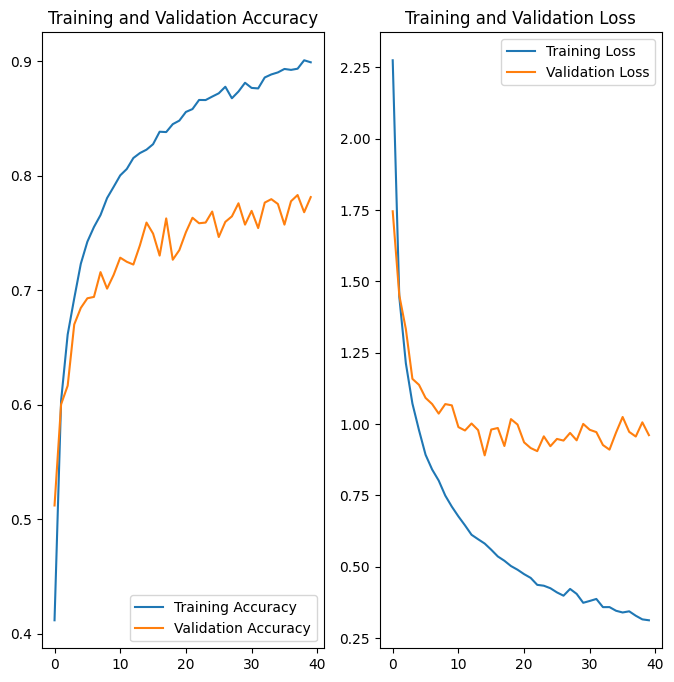

In [39]:
import matplotlib.pyplot as plt

EPOCHS = 40

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

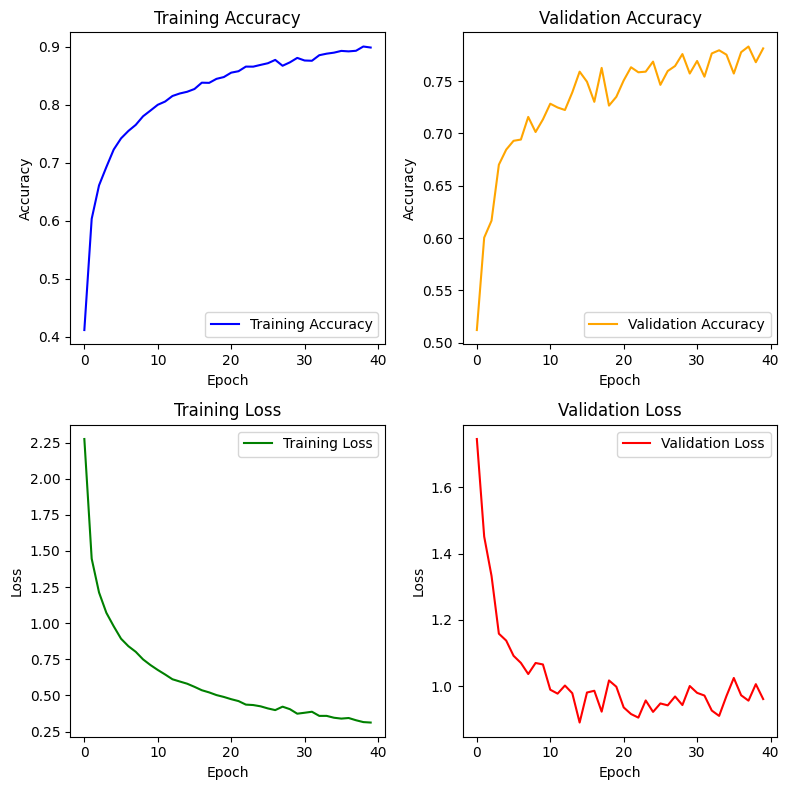

In [40]:
import matplotlib.pyplot as plt

EPOCHS = 40

# Plot Training Accuracy
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training Loss
plt.subplot(2, 2, 3)
plt.plot(range(EPOCHS), loss, label='Training Loss', color='green')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot Validation Loss
plt.subplot(2, 2, 4)
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

First image to predict
Actual label: Clematis hirsuta - simensis
1/1 [==============================] - 3s 3s/step
Predicted label: Clematis hirsuta - simensis


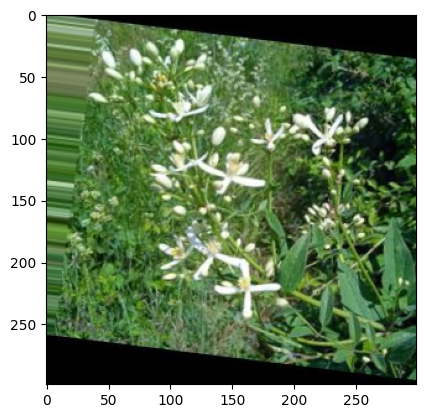

In [41]:
import numpy as np

for images_batch, labels_batch in test_generator:
   
    first_image = images_batch[0]
    first_label = np.argmax(labels_batch[0])  # Use np.argmax to get the class index

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_predictions = model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_predictions[0])]  # Use np.argmax for categorical class mode
    print("Predicted label:", predicted_label)

    break

1/1 [==============================] - 0s 59ms/step


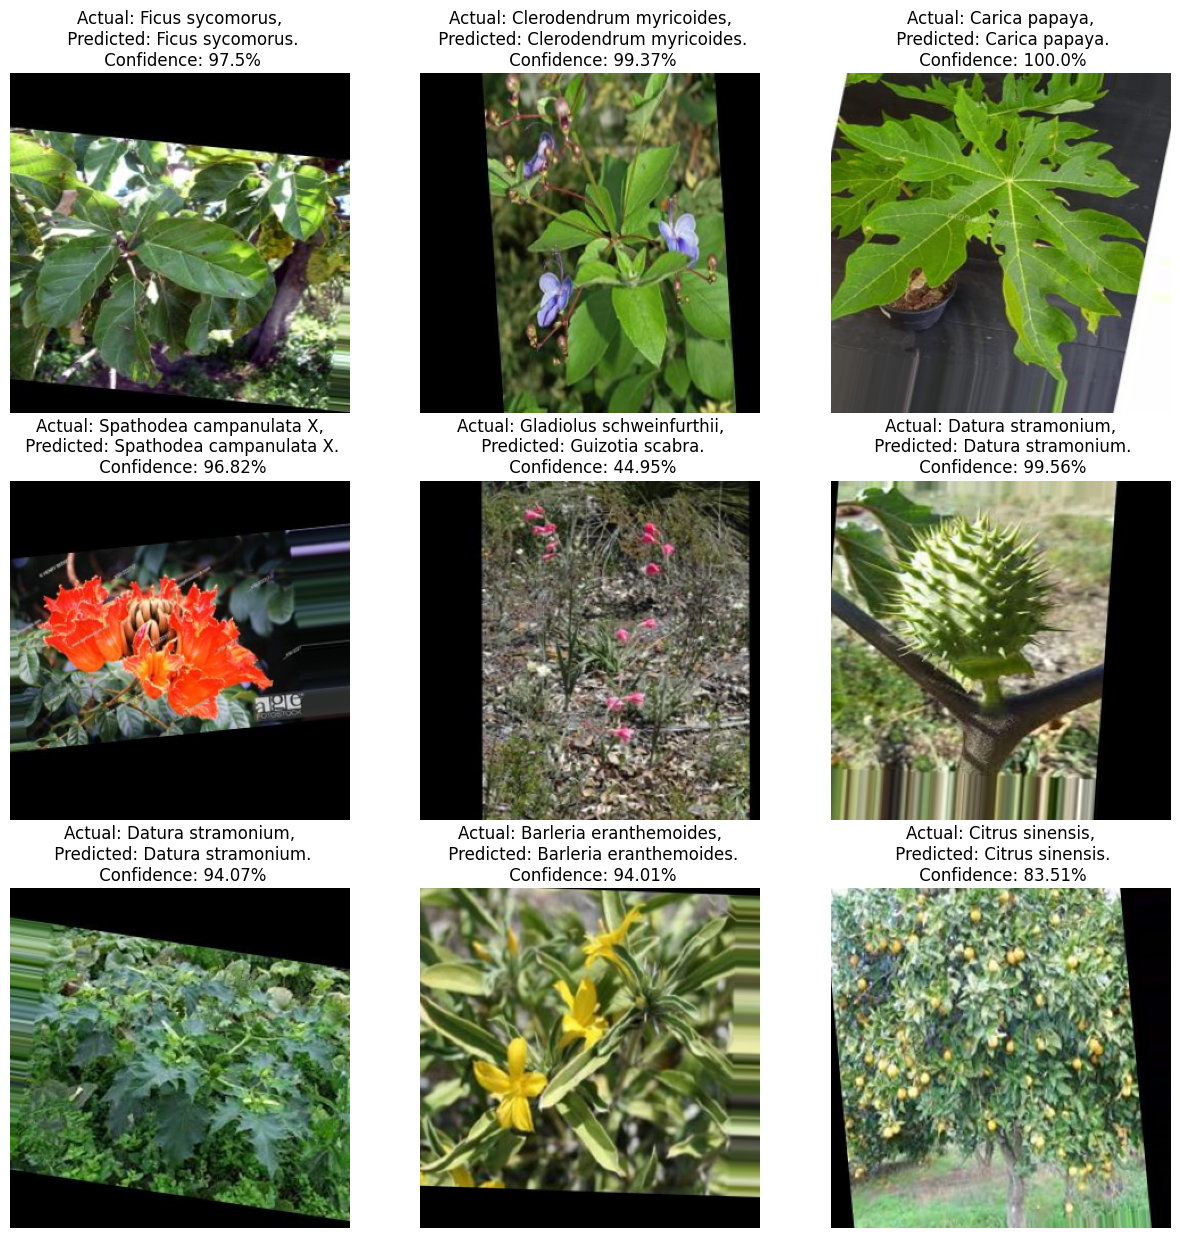

In [66]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])]  # Access class_names using np.argmax

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

1/1 [==============================] - 0s 50ms/step


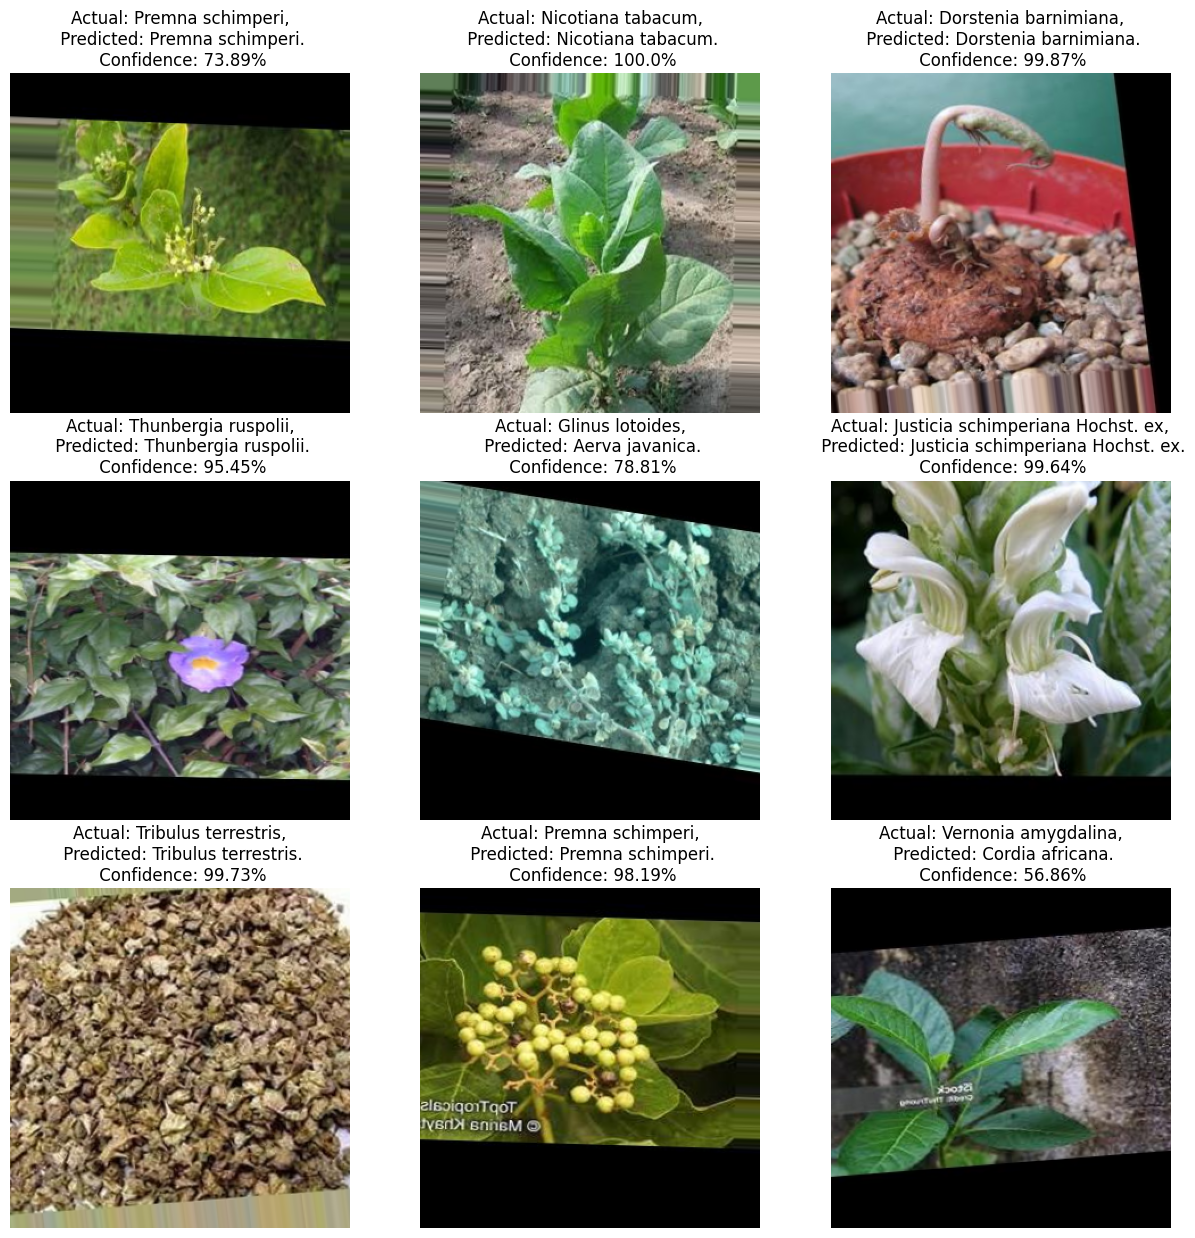

In [67]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])]  # Access class_names using np.argmax

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

1/1 [==============================] - 0s 57ms/step


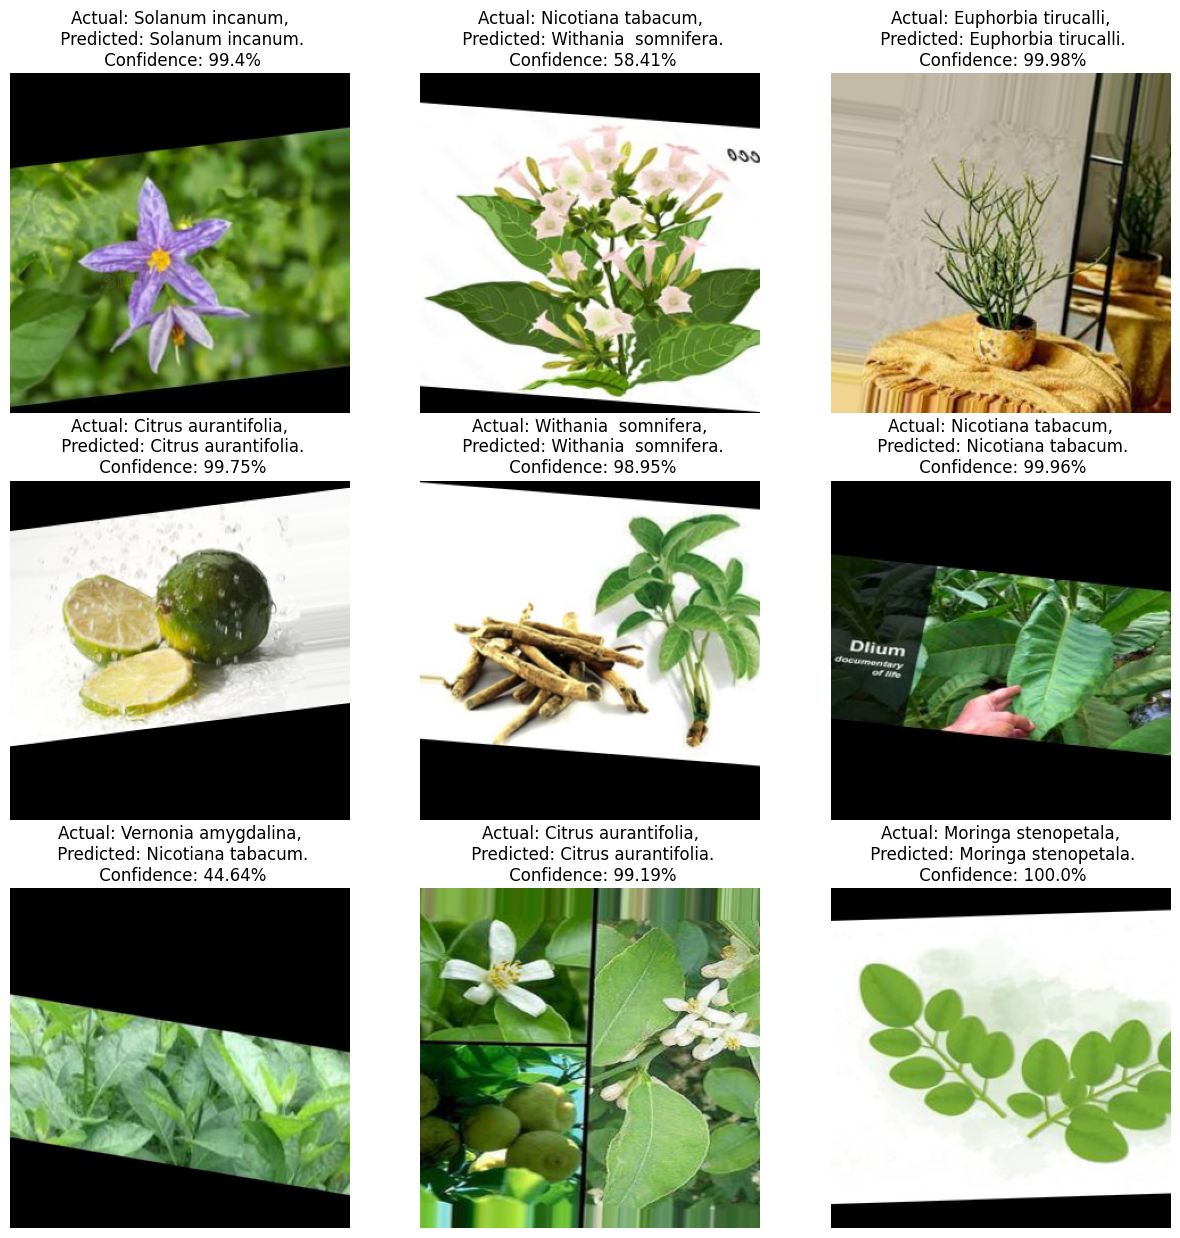

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[np.argmax(labels[i])]  # Access class_names using np.argmax

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

In [71]:
model.save("saved_models/TrainedModel3_InceptionResNetV2.h5")

In [72]:
model.save("saved_models/TrainedModel2_InceptionResNetV2.keras")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("saved_models/TrainedModel3_InceptionResNetV2.tflite", 'wb') as f:
  f.write(tflite_model)